In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
# read in each networkx files and associated years
gexf_path = "gexf_files/"
fig_path = "figures/"
files = !cd "gexf_files/"; find G*_fixed.gexf
files = ['G2004.gexf'] + files
print(files)
networks = [nx.read_gexf(gexf_path+file) for file in files]
years = [int(file[1:5]) for file in files]

['G2004.gexf', 'G2006_fixed.gexf', 'G2008_fixed.gexf', 'G2010_fixed.gexf', 'G2012_fixed.gexf', 'G2014_fixed.gexf', 'G2016_fixed.gexf', 'G2018_fixed.gexf', 'G2020_fixed.gexf', 'G2022_fixed.gexf']


In [3]:
# get list of rap nodes
def isRap(s):
    s_low = s.lower()
    return "rap" in s_low or "hip hop" in s_low or "trap" in s_low

rap_nodes = [set() for i in networks]
for i, G in enumerate(networks):
    for node, data in G.nodes(data=True):
        if isRap(data['genre']): rap_nodes[i].add(node)

# Degree Distribution

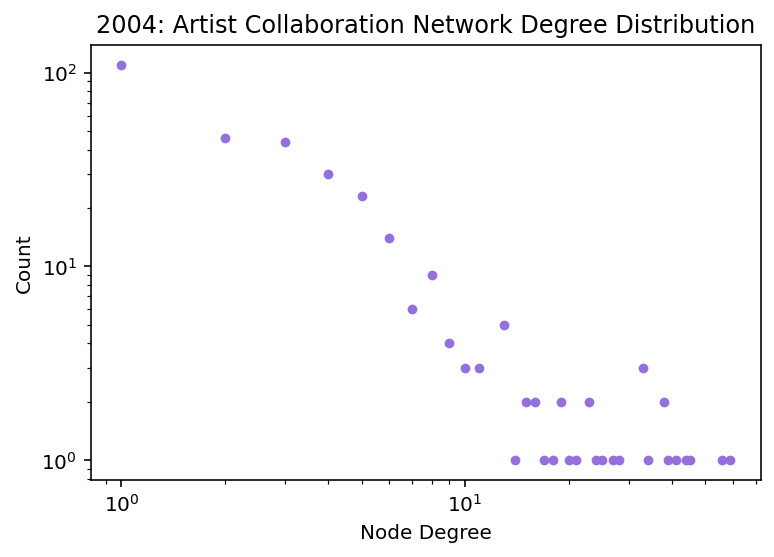

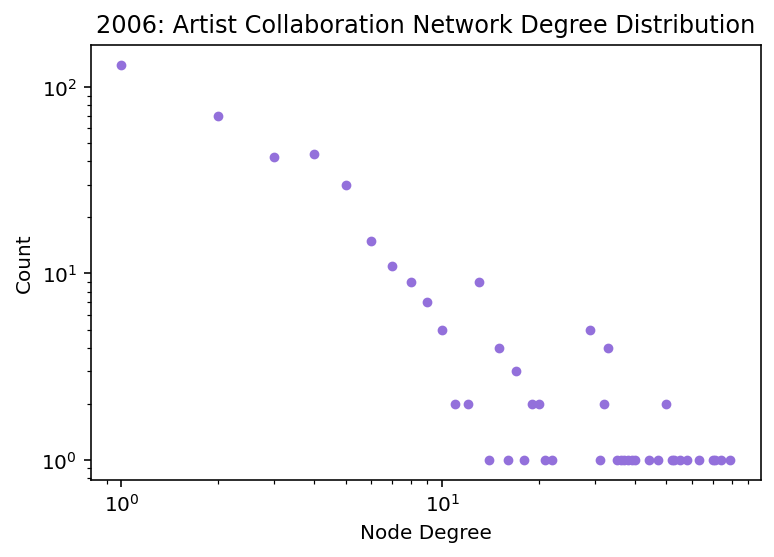

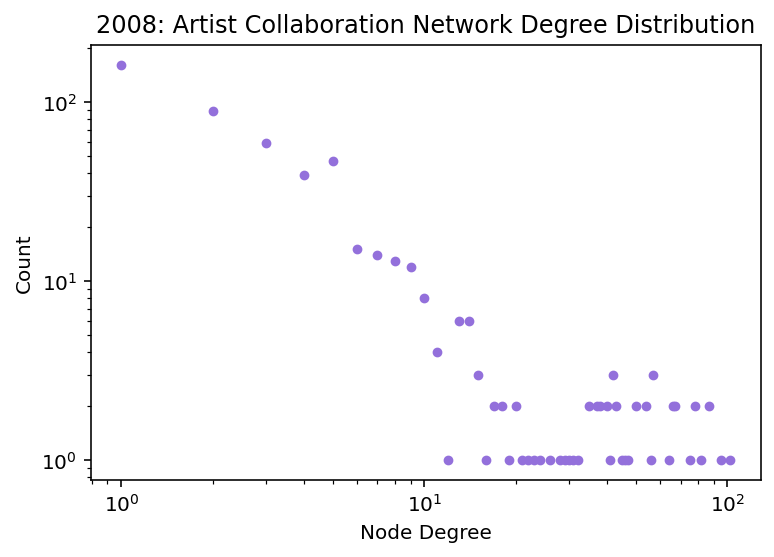

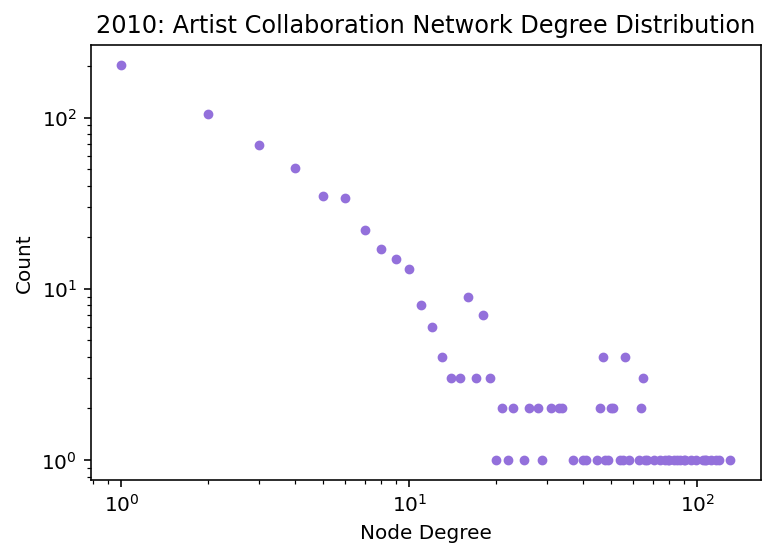

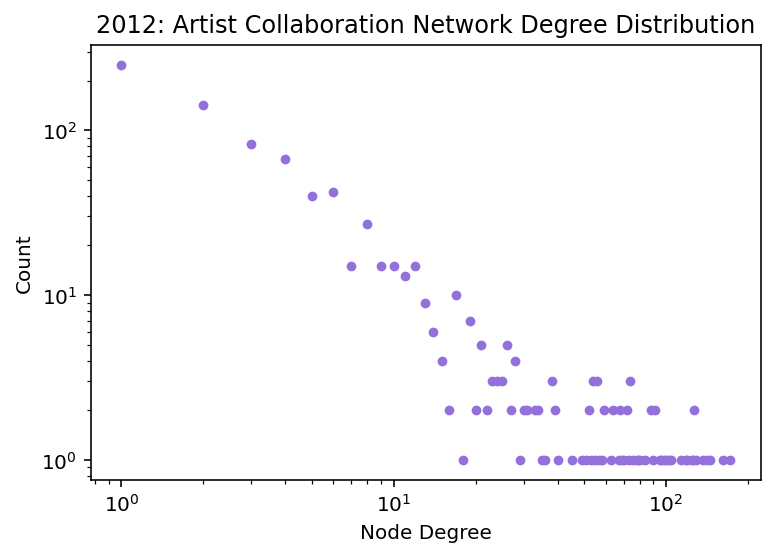

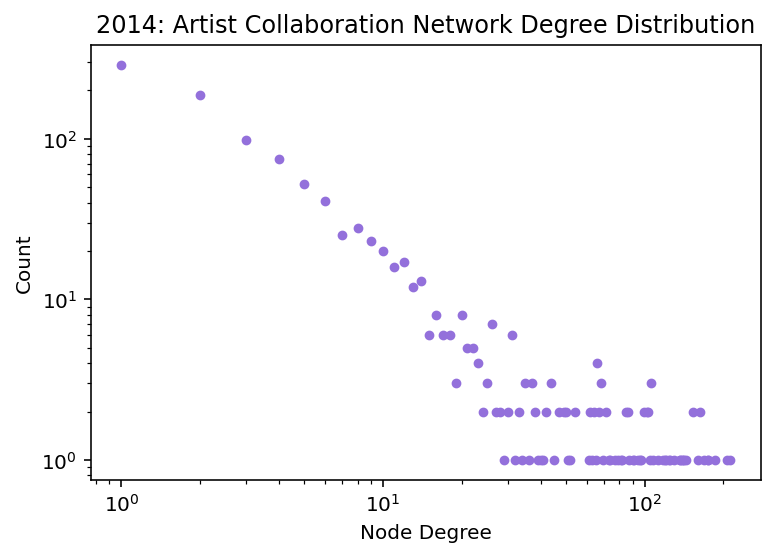

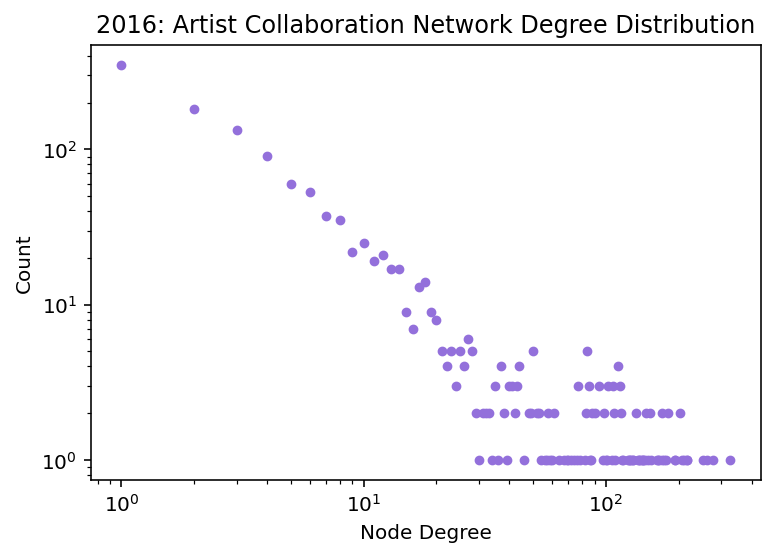

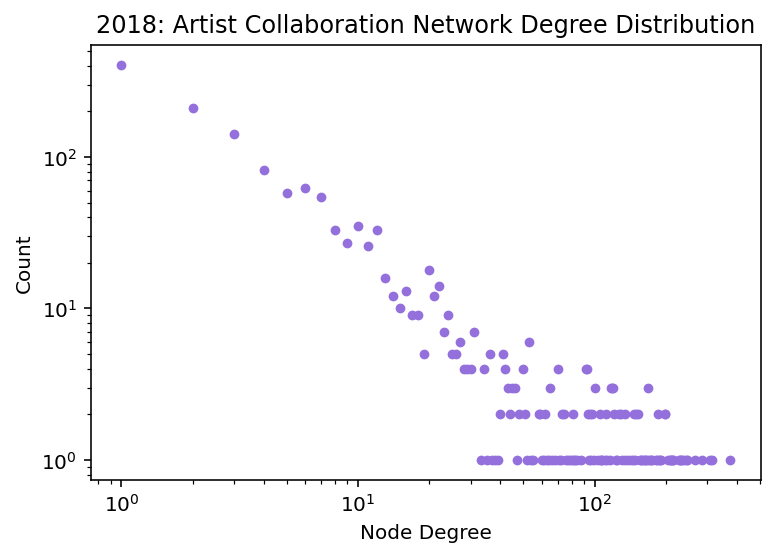

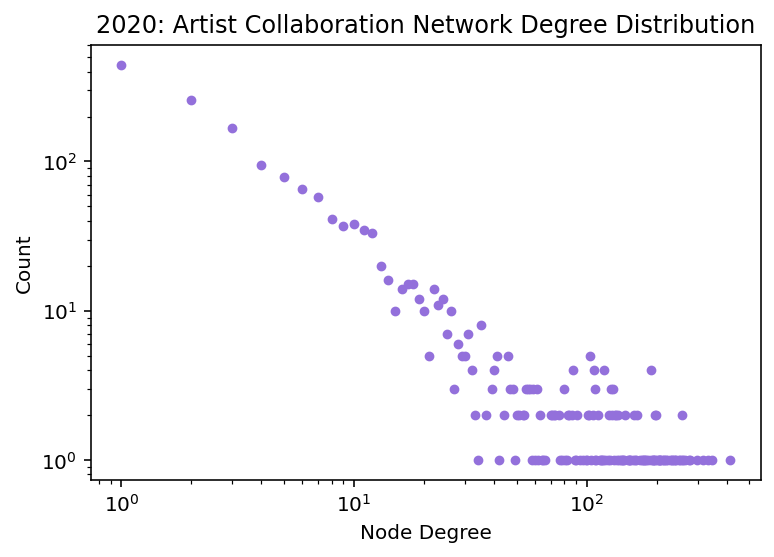

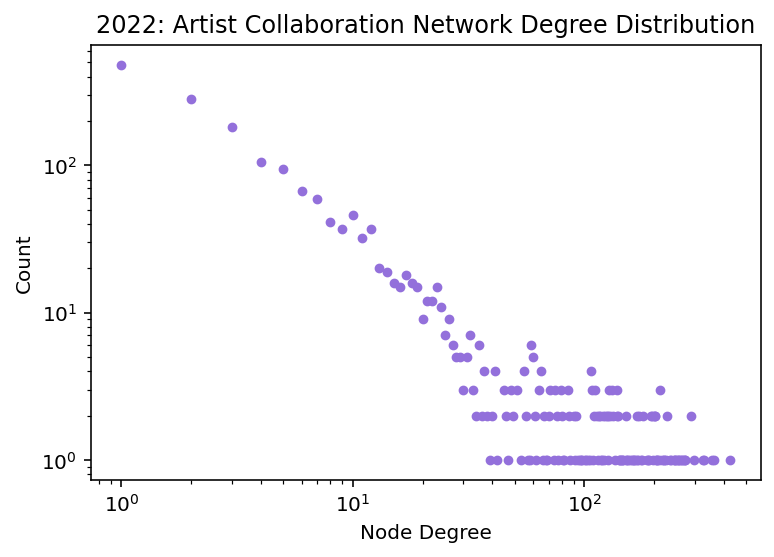

In [4]:
# plot degree distribution for each year
for i, G in enumerate(networks):
    G_all_deg = [deg[1] for deg in G.degree()]
    G_deg, G_deg_counts = np.unique(G_all_deg, return_counts=True)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    plt.scatter(G_deg, G_deg_counts, c="mediumpurple", sizes=[15])
    
    title = f"{years[i]}: Artist Collaboration Network Degree Distribution"
    plt.title(title)
    plt.xlabel("Node Degree")
    plt.ylabel("Count")
    
    plt.savefig(fig_path+title)
    plt.show()

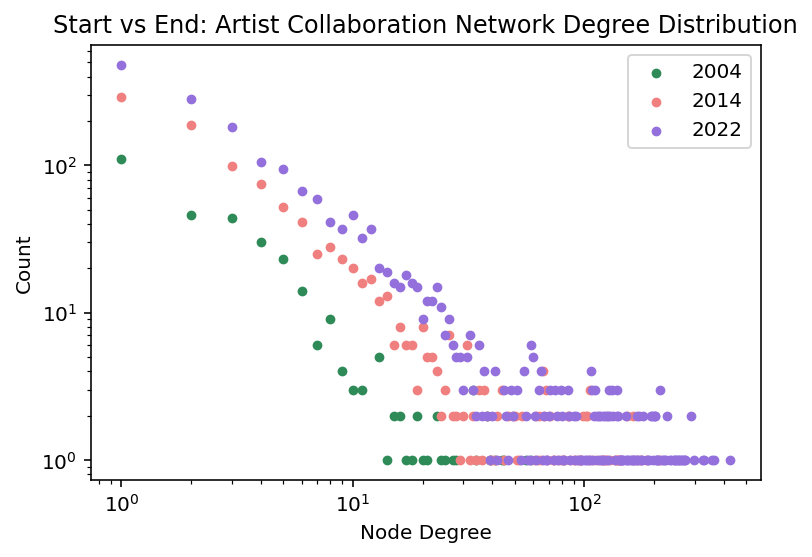

In [8]:
# overlay degree distribution for initial (2004), meaningful (2014) and final (2022) networks

# define years and associated colors
idxs = [0, 5, -1]
colors = ["seagreen", "lightcoral", "mediumpurple"]

# get unique degree counts for given years by index
G_all_degs = [[deg[1] for deg in networks[idx].degree()] for idx in idxs]
G_degs, G_deg_counts = [0 for i in idxs], [0 for i in idxs]
for i,G_all_deg in enumerate(G_all_degs):
    G_degs[i], G_deg_counts[i] = np.unique(G_all_deg, return_counts=True)

# plot and save the change in degree distribution as a single graph
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.set_xscale('log')

for i, idx in enumerate(idxs):
    plt.scatter(G_degs[i], G_deg_counts[i], c=colors[i], sizes=[15], label=years[idx])

title = f"Start vs End: Artist Collaboration Network Degree Distribution"
plt.title(title)
plt.xlabel("Node Degree")
plt.ylabel("Count")
plt.legend()

plt.savefig(fig_path+title)
plt.show()

# Average Clustering Coefficient

In [11]:
avg_ccs = [nx.average_clustering(network) for network in networks]
rap_avg_ccs = [nx.average_clustering(network.subgraph(rap_nodes[i])) for i, network in enumerate(networks)]

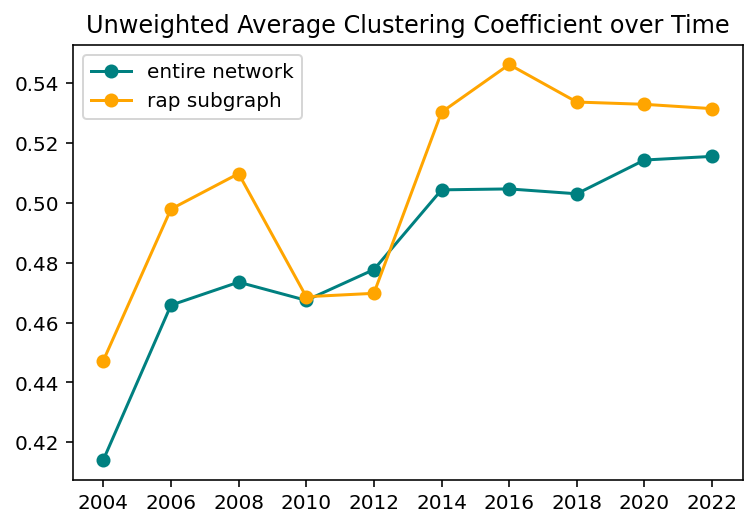

In [15]:
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(years,avg_ccs,marker="o",c="teal", label="entire network")
ax.plot(years,rap_avg_ccs,marker="o",c="orange", label="rap subgraph")
title = "Unweighted Average Clustering Coefficient over Time"
ax.set_title(title)
ax.legend()
plt.savefig(fig_path+title)
plt.show()

# Assortativity

In [32]:
# calculate binary assortativity, since there are exactly two classes from above
# here, I defined an X-chacteristic edge as an edge with matching node kinds

# define variables
chicago_assorts, k_vals = np.zeros(len(networks)), np.zeros(len(networks))
label, start_genre = "genre", "chicago rap"

# for each network calculate assortativity
for i, G in enumerate(networks):
    num_chicago_rappers = len([v for k,v in G.nodes(data=label) if v == start_genre])

    # calculate assortativity (expected num char edges)
    p = num_chicago_rappers/len(G.nodes)
    q = 1 - p
    assortativity = 2*p*q
    
    # calculate k (actual num char edges)
    k_edges = len([1 for node1, node2 in G.edges if G.nodes[node1][label] != G.nodes[node2][label]])
    k = k_edges/len(G.edges)
    
    chicago_assorts[i], k_vals[i] = assortativity, k
    print(f"{years[i]}: Assortativity test: 2pq = {assortativity:.5f} << {k:.5f} = k")

2004: Assortativity test: 2pq = 0.02840 << 0.86848 = k
2006: Assortativity test: 2pq = 0.02678 << 0.87647 = k
2008: Assortativity test: 2pq = 0.02131 << 0.88053 = k
2010: Assortativity test: 2pq = 0.03575 << 0.88092 = k
2012: Assortativity test: 2pq = 0.06210 << 0.88547 = k
2014: Assortativity test: 2pq = 0.07454 << 0.88820 = k
2016: Assortativity test: 2pq = 0.07490 << 0.90044 = k
2018: Assortativity test: 2pq = 0.07441 << 0.90743 = k
2020: Assortativity test: 2pq = 0.06949 << 0.91062 = k
2022: Assortativity test: 2pq = 0.06623 << 0.91135 = k


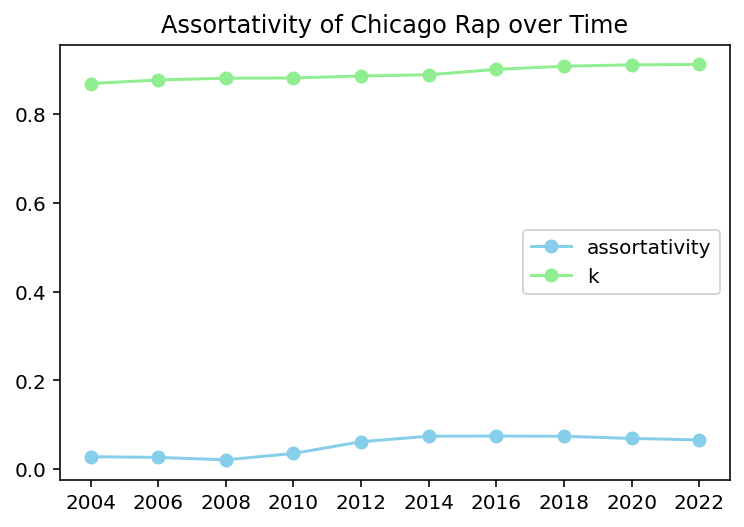

In [33]:
# plot chicago rap assortativity
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.plot(years,chicago_assorts,marker="o",c="skyblue", label="assortativity")
ax.plot(years,k_vals,marker="o",c="lightgreen", label="k")
title = "Assortativity of Chicago Rap over Time"
ax.set_title(title)
ax.legend()
plt.savefig(fig_path+title)
plt.show()

In [16]:
# same thing but for the rap genre

# define variables
rap_assorts, rap_k_vals = np.zeros(len(networks)), np.zeros(len(networks))

# for each network calculate assortativity
for i, G in enumerate(networks):
    rap_set = rap_nodes[i]
    num_rappers = len(rap_set)

    # calculate assortativity (expected num char edges)
    p = num_rappers/len(G.nodes)
    q = 1 - p
    assortativity = 2*p*q
    
    # calculate k (actual num char edges)
    k_edges = len([1 for node1, node2 in G.edges if node1 in rap_set != node2 not in rap_set])
    k = k_edges/len(G.edges)
    
    rap_assorts[i], rap_k_vals[i] = assortativity, k
    print(f"{years[i]}: Assortativity test: 2pq = {assortativity:.5f} > {k:.5f} = k")

2004: Assortativity test: 2pq = 0.47000 > 0.18707 = k
2006: Assortativity test: 2pq = 0.46556 > 0.19431 = k
2008: Assortativity test: 2pq = 0.46886 > 0.21038 = k
2010: Assortativity test: 2pq = 0.47793 > 0.20934 = k
2012: Assortativity test: 2pq = 0.49313 > 0.19868 = k
2014: Assortativity test: 2pq = 0.49759 > 0.18955 = k
2016: Assortativity test: 2pq = 0.49921 > 0.19742 = k
2018: Assortativity test: 2pq = 0.49957 > 0.20195 = k
2020: Assortativity test: 2pq = 0.49929 > 0.20432 = k
2022: Assortativity test: 2pq = 0.49950 > 0.20235 = k


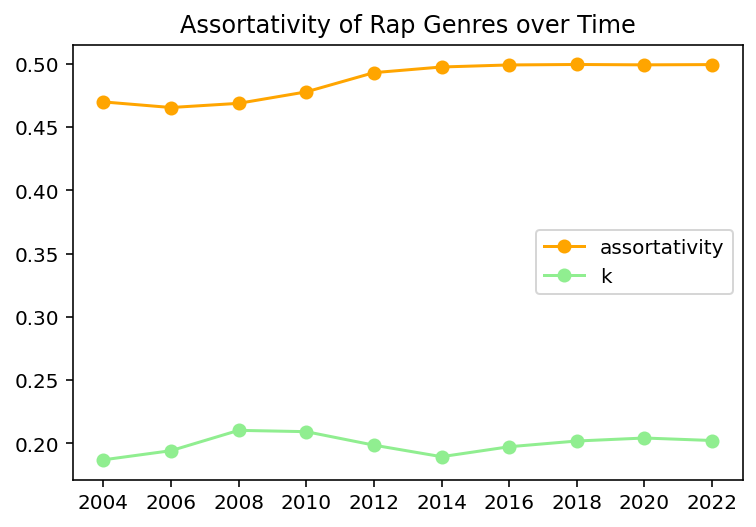

In [17]:
# plot rap genre assortativity
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.plot(years,rap_assorts,marker="o",c="orange", label="assortativity")
ax.plot(years,rap_k_vals,marker="o",c="lightgreen", label="k")
title = "Assortativity of Rap Genres over Time"
ax.set_title(title)
ax.legend()
plt.savefig(fig_path+title)
plt.show()